In [ ]:
## Summary of the File

This file shows how we build up the monkey model, from a single pendulum, then a double pendulum, then moving the masses to the middle.
Next would be to move the actuators to the shoulders, and introduce a body; however, THAT WAS NOT FINISHED. This should be your first task when taking over this project. Another key problem would be getting a good constraint for not crossing over the bars. I tried a few things, which have varying success in different regimes. 
What you can do. Each block is summarized.  
i) a helper function for calling lqr for visualizing a urdf if initial conditions are already stable. I would recommend just using meshcat for this though.
ii) A generic function for performing LQR.
iii) the single pendulum and lqr
iv) the double pendulum and lqr
v) introducing the monkey bars into a urdf with a double pendulum
vi) lqr with this
vii) a block with a simple way of using direct collocation. 
viii) a block doing the direct collocation on the double pendulum
ix) changing the positions of the masses in the urdf, and changing constraints/cost
x - xiv) ideas for future additions

In [ ]:
## This block handles the imports
# others
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import math


# drake
from pydrake.all import (MultibodyPlant, Parser, DiagramBuilder, Simulator,
                         PlanarSceneGraphVisualizer, SceneGraph, TrajectorySource,
                         SnoptSolver, MultibodyPositionToGeometryPose, PiecewisePolynomial,
                         MathematicalProgram, JacobianWrtVariable, eq)
from pydrake.all import (AddMultibodyPlantSceneGraph, DiagramBuilder,
                         LinearQuadraticRegulator, Parser,
                         PlanarSceneGraphVisualizer, Simulator, Linearize)
from pydrake.all import (AddMultibodyPlantSceneGraph, DiagramBuilder,
                         LogVectorOutput, MeshcatVisualizerCpp, MultibodyPlant,
                         Parser, Simulator, StartMeshcat, ToLatex, Variable,
                         VectorSystem)
from underactuated import (FindResource, ManipulatorDynamics,
                           running_as_notebook)
#direct col
from pydrake.all import (DiagramBuilder, DirectCollocation, MultibodyPlant,
                         MultibodyPositionToGeometryPose, Parser,
                         PiecewisePolynomial, PlanarSceneGraphVisualizer,
                         SceneGraph, Simulator, Solve, TrajectorySource)


from underactuated import FindResource

## NullController Helper Function (Not Necessary)

In [ ]:
class NullController(VectorSystem):
    """Defines a feedback controller for the double pendulum.

    The controller applies torques at the joints in order to:

    1) cancel out the dynamics of the double pendulum,
    2) make the first joint swing with the dynamics of a single pendulum, and
    3) drive the second joint towards zero.

    The magnitude of gravity for the imposed single pendulum dynamics is taken
    as a constructor argument.  So you can do fun things like pretending that
    gravity is zero, or even inverting gravity!
    """

    def __init__(self, multibody_plant, ins, outs):
        # 4 inputs (double pend state), 2 torque outputs.
        self.ins = ins
        self.outs = outs
        VectorSystem.__init__(self, ins, outs)
        self.plant = multibody_plant
        self.g = 9.8

    def DoCalcVectorOutput(self, context, double_pend_state, unused, torque):
        # Extract manipulator dynamics.
        q = double_pend_state[:self.outs]
        v = double_pend_state[-self.outs:]
        (M, Cv, tauG, B, tauExt) = ManipulatorDynamics(self.plant, q, v)

        # Desired pendulum parameters.
        length = 2.
        b = .1

        # Control gains for stabilizing the second joint.
        kp = 1
        kd = .1

        # Cancel double pend dynamics and inject single pend dynamics.
        torque[:] = Cv - tauG - tauExt + M.dot(
            [self.g / length * np.sin(q[0]) - b * v[0], -kp * q[1] - kd * v[1]])

## Function for Generic LQR call and visualize

In [ ]:
# first 6 args self-explanatory, x0 is starting point for simulation
# sim_time, xlim, ylim are for the simulation
# null_controller only set to true if can't find a x_star, u_star to stabilize around. 
def do_LQR(this_urdf, x_star, u_star, x0, Q, R, sim_time = 5, xlim=[-5, 5], ylim=[-5, 5], null_controller = False):
    # start construction site of our block diagram
    builder = DiagramBuilder()

    # instantiate the plant and the scene graph
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    Parser(plant).AddModelFromString(this_urdf, "urdf")
    plant.Finalize()

    # set the operating point (vertical unstable equilibrium)
    context = plant.CreateDefaultContext()
    context.get_mutable_continuous_state_vector().SetFromVector(x_star)

    # fix the input port to zero and get its index for the lqr function
    plant.get_actuation_input_port().FixValue(context, u_star) #this vector is for the u0-star
    input_i = plant.get_actuation_input_port().get_index()

    # synthesize lqr controller directly from the nonlinear system and the operating point
    # null controller is used to simply look at the system without having to find a stable equilibrium
    if null_controller:
        lqr = NullController(plant, len(x_star), len(u_star))       
    else:
        lqr = LinearQuadraticRegulator(plant, context, Q, R, input_port_index=int(input_i))
    lqr = builder.AddSystem(lqr)

    # the following two lines are not needed here...
    output_i = plant.get_state_output_port().get_index()
    plant_lin = Linearize(plant,
                             context,
                             input_port_index=input_i,
                            output_port_index=output_i)

    # wire cart-pole and lqr
    builder.Connect(plant.get_state_output_port(), lqr.get_input_port(0))
    builder.Connect(lqr.get_output_port(0), plant.get_actuation_input_port())

    # add a visualizer and wire it
    visualizer = builder.AddSystem(
        PlanarSceneGraphVisualizer(scene_graph, xlim=xlim, ylim=ylim, show=False)
    )
    builder.Connect(scene_graph.get_query_output_port(), visualizer.get_input_port(0))

    # finish building the block diagram
    diagram = builder.Build()


    ### SIMULATE AND ANIMATE THE PLANT ###

    # instantiate a simulator
    simulator = Simulator(diagram)
    simulator.set_publish_every_time_step(False) # makes sim faster

    # start recording the video for the animation of the simulation
    visualizer.start_recording()

    # reset initial time and state
    context = simulator.get_mutable_context()
    context.SetTime(0.)
    context.SetContinuousState(x0)

    # run sim
    simulator.Initialize()
    simulator.AdvanceTo(sim_time)

    # stop video
    visualizer.stop_recording()

    # construct animation
    ani = visualizer.get_recording_as_animation()

    # display animation below the cell
    display(HTML(ani.to_jshtml()))

    # reset to empty video
    visualizer.reset_recording()


## Single Pendulum
- urdf
- call with parameters

In [ ]:
PENDULUM_URDF = """
<?xml version="1.0" ?>

<robot name="pendulum">

  <!-- roof -->
  <!-- just for visualization, it is welded to world -->

  <link name="roof">

    <visual>
      <origin xyz="0 0 1" rpy="0 0 0"/>
      <geometry>
        <box size="10 .375 .5" />
      </geometry>
      <material name="green">
        <color rgba="0 1 0 1" />
      </material>
    </visual>

  </link>

  <joint name="roof_is_world" type="fixed">

    <parent link="world" />
    <child link="roof" />
    <!-- slope of the ramp here -->
    <origin xyz="0 0 0" rpy="0 0 0"/>

  </joint>

  <!-- pendulum hanging from ceiling -->

  <link name="pendulum">
    <inertial>
      <origin xyz="0 0 -1.5" />
      <mass value="1" />
    </inertial>

    <visual>
      <origin xyz="0 0 -1.5" />
      <geometry>
         <sphere radius=".2" />
      </geometry>
      <material>
        <color rgba="0 0 1 1" />
      </material>
    </visual>

    <visual>
      <origin xyz="0 0 -.75" />
      <geometry>
         <cylinder length="1.5" radius=".1" />
      </geometry>
      <material>
        <color rgba="1 0 0 1" />
      </material>
    </visual>
  </link>

  <joint name="ceiling_link" type="continuous">
    <parent link="roof" />
    <child link="pendulum" />
    <axis xyz="0 -1 0" />
    <origin xyz="0 0 1"/>
  </joint>

  <transmission type="SimpleTransmission" name="base_force">
    <actuator name="force" />
    <joint name="ceiling_link" />
  </transmission>
  
</robot>
"""

In [ ]:
urdf = PENDULUM_URDF

x_star = [np.pi, 0]
u_star = [0]
x0 = [0,0]

# weight matrices for the lqr controller*
Q = np.diag((8, 1))
R = .1*np.eye(1)

xlim = [-6,6]
ylim = [-5,5]

do_LQR(urdf, x_star, u_star, x0, Q, R, sim_time = 2, xlim=xlim, ylim=ylim)

## Double Pendulum
- urdf
- call with parameters

In [ ]:
PENDULUM2_URDF = """
<?xml version="1.0" ?>

<robot name="pendulum">

  <!-- roof -->
  <!-- just for visualization, it is welded to world -->

  <link name="roof">

    <visual>
      <origin xyz="0 0 0" rpy="0 0 0"/>
      <geometry>
        <box size="10 .375 .15" />
      </geometry>
      <material name="green">
        <color rgba="0 1 0 1" />
      </material>
    </visual>

  </link>

  <joint name="roof_is_world" type="fixed">

    <parent link="world" />
    <child link="roof" />
    <!-- slope of the ramp here -->
    <origin xyz="0 0 0" rpy="0 0 0"/>

  </joint>

  <!-- pendulum hanging from ceiling -->

  <link name="pendulum">
    <inertial>
      <origin xyz="0 0 -1.5" />
      <mass value="1" />
    </inertial>

    <visual>
      <origin xyz="0 0 -1.5" />
      <geometry>
         <sphere radius=".2" />
      </geometry>
      <material>
        <color rgba="0 0 1 1" />
      </material>
    </visual>

    <visual>
      <origin xyz="0 0 -.75" />
      <geometry>
         <cylinder length="1.5" radius=".1" />
      </geometry>
      <material>
        <color rgba="1 0 0 1" />
      </material>
    </visual>
  </link>

  <joint name="ceiling_link" type="continuous">
    <parent link="roof" />
    <child link="pendulum" />
    <axis xyz="0 -1 0" />
    <origin xyz="0 0 0"/>
  </joint>

  <!-- pendulum hanging from other pendulum -->

  <link name="arm2">
    <inertial>
      <origin xyz="0 0 -1.5" />
      <mass value="1" />
    </inertial>

    <visual>
      <origin xyz="0 0 -1.5" />
      <geometry>
         <sphere radius=".2" />
      </geometry>
      <material>
        <color rgba="0 0 1 1" />
      </material>
    </visual>

    <visual>
      <origin xyz="0 0 -.75" />
      <geometry>
         <cylinder length="1.5" radius=".1" />
      </geometry>
      <material>
        <color rgba="1 0 0 1" />
      </material>
    </visual>
  </link>

  <joint name="arm2link" type="continuous">
    <parent link="pendulum" />
    <child link="arm2" />
    <axis xyz="0 -1 0" />
    <origin xyz="0 0 -1.5"/>
  </joint>

  <transmission type="SimpleTransmission" name="base_force">
    <actuator name="force" />
    <joint name="ceiling_link" />
  </transmission>
  
  <transmission type="SimpleTransmission" name="arm2_force">
    <actuator name="force1" />
    <joint name="arm2link" />
  </transmission>
  
</robot>
"""

In [ ]:
urdf = PENDULUM2_URDF
u_star = [0,0]
x_star = [np.pi, 0, 0, 0]
x0 = [0,0, 0, 0]

# weight matrices for the lqr controller*
Q = np.diag((8, 8, 0,0))
R = .001*np.eye(2)

xlim = [-6,6]
ylim = [-5,5]

do_LQR(urdf, x_star, u_star, x0, Q, R, sim_time = 6, xlim=xlim, ylim=ylim)

## Including the bars
- Base URDF
- Bars URDF
- call with parameters

In [ ]:
MONKEY_BASE = """
  <!-- pendulum hanging from ceiling -->

  <link name="pendulum">
    <inertial>
      <origin xyz="0 0 -1" />
      <mass value="1" />
    </inertial>

    <visual>
      <origin xyz="0 0 -1" />
      <geometry>
         <sphere radius=".1" />
      </geometry>
      <material>
        <color rgba="0 0 1 1" />
      </material>
    </visual>

    <visual>
      <origin xyz="0 0 -.5" />
      <geometry>
         <cylinder length="1" radius=".05" />
      </geometry>
      <material>
        <color rgba="1 0 0 1" />
      </material>
    </visual>
  </link>

  <joint name="ceiling_link" type="continuous">
    <parent link="bar0" />
    <child link="pendulum" />
    <axis xyz="0 -1 0" />
    <origin xyz="0 0 0"/>
  </joint>

  <!-- pendulum hanging from other pendulum -->

  <link name="arm2">
    <inertial>
      <origin xyz="0 0 -1" />
      <mass value="1" />
    </inertial>

    <visual>
      <origin xyz="0 0 -1" />
      <geometry>
         <sphere radius=".1" />
      </geometry>
      <material>
        <color rgba="0 0 1 1" />
      </material>
    </visual>

    <visual>
      <origin xyz="0 0 -.5" />
      <geometry>
         <cylinder length="1" radius=".05" />
      </geometry>
      <material>
        <color rgba="1 0 0 1" />
      </material>
    </visual>
  </link>

  <joint name="arm2link" type="continuous">
    <parent link="pendulum" />
    <child link="arm2" />
    <axis xyz="0 -1 0" />
    <origin xyz="0 0 -1"/>
  </joint>
  
  <transmission type="SimpleTransmission" name="base_force">
    <actuator name="force" />
    <joint name="ceiling_link" />
  </transmission>
  
<transmission type="SimpleTransmission" name="arm2_force">
    <actuator name="force1" />
    <joint name="arm2link" />
  </transmission>
"""


In [ ]:
# Creating the bars
monkey_bar = """ 
    <link name="barNUMBER">
        <inertial>
            <origin xyz="0 0 0" />
            <mass value="1" />
        </inertial>

        <visual>
            <origin xyz="0 0 0" />
            <geometry>
                <box size=".3 .3 .3" />
            </geometry>
            <material>
                <color rgba="0 0 0 .9" />
            </material>
        </visual>
    </link>
    
    <joint name="bar_jointNUMBER" type="fixed">
        <parent link="world" />
        <child link="barNUMBER" />
        <origin xyz="XVAL 0 HEIGHT" />
    </joint>
"""

def create_monkey_urdf(body_urdf, bar_params, link_params=None):

    #bar params is [[xorigin, gap1, gap2, ...], [yorigin, gap1, gap2, ...]]
    bar_gaps_x = bar_params[0]
    bar_gaps_z = bar_params[1]
    

    #urdf monkey outline
    urdf = """
        <?xml version="1.0" ?>
        <robot name="monkey">
        BAR
        BASE
        </robot>
        """
    
    # CREATE THE MONKEY BARS
    bar_x, bar_z = 0, 0
    for i in range(len(bar_gaps_x)):
        bar_x += bar_gaps_x[i]
        bar_z += bar_gaps_z[i]
        urdf = urdf.replace("BAR", monkey_bar.\
                    replace("NUMBER", str(i)).\
                    replace("XVAL", str(bar_x)).\
                    replace("HEIGHT", str(bar_z)) + "BAR")
    urdf = urdf.replace("BAR", "")


    # CREATE THE MONKEY BASE
    urdf = urdf.replace("BASE", body_urdf)
    

    #floating base init
    #urdf = urdf.replace("JOINT", base_joint_x + "JOINT")
    #urdf = urdf.replace("JOINT", base_joint_z)

    return urdf

MAX_STRETCH = 2 # right now 2 pendulums, length 1, but could be with body as well
def make_random_bars_urdf(num_bars, x_range, z_range):
    bar_shifts_x = x_range[0] + (x_range[1] - x_range[0]) * np.random.rand(num_bars) #randomly generate the bars
    zmaxes = (MAX_STRETCH**2 - bar_shifts_x**2) ** (1/2)
    zmaxes = np.array([min(z_range[1]-z_range[0], zmax - z_range[0]) for zmax in zmaxes])
    bar_shifts_z = z_range[0] + zmaxes * np.random.rand(num_bars)

    bar_shifts_x = np.insert(bar_shifts_x, 0, 0) #insert the starting bars 
    bar_shifts_z = np.insert(bar_shifts_z, 0, 0)

    bar_params = [bar_shifts_x,  bar_shifts_z]
    bar1 = np.array([bar_shifts_x[1], bar_shifts_z[1]])
    
    return create_monkey_urdf(MONKEY_BASE, bar_params), bar1

## Next Block

You can uncomment the lines to see a swingup again like with the pendulums. 

In [ ]:
X_RANGE = [1, 1.5]
Z_RANGE = [-.5, .75]
num_bars = 6#np.random.randint(1, 6)
urdf, bar1 = make_random_bars_urdf(num_bars, X_RANGE, Z_RANGE)

#x_star = [np.pi, 0, 0, 0]
#u_star = [0,0]
#x0 = [0, 0, 0, 0]

# weight matrices for the lqr controller*
#Q = np.diag((8, 8, 0,0))
#R = .01*np.eye(2)

#xlim = [-2, 10]
#ylim = [-8, 3]

#do_LQR(urdf, x_star, u_star, x0, Q, R, sim_time = 6, xlim=xlim, ylim=ylim)

In [ ]:
def compute_final_thetas(r, barpos):
    x,z = barpos
    hyp = (x**2 + z**2)**(1/2)
    print('hyp = ', hyp)
    #now we have 3 sides of a triangle
    
    theta2 = np.pi - np.arccos((2*r**2 - hyp**2 ) / (2*r**2)) #from law of cosines
    print(theta2)
    alpha = np.arccos((hyp**2) / (2*r*hyp)) #the angle inside of the triangle near the first hand 
    
    #now we compute c by summing vectors in b direction and orthogonal
    base = np.cos(alpha)*r
    height = np.sin(alpha)*r
    cx = (x*base + z * height) / hyp
    cz = (z*base - x * height) / hyp
    print('cx = ', cx)
    print('cz = ', cz)
    print(cx**2 + cz**2)

    #with c given, we can compute an equivalent angle to theta 1 by dropping a line from the origin to c
    theta1 = (0 if cz < 0 else np.pi) #based on how we draw it
    magcz = (cz**2)**(1/2)
    theta1 += np.arccos((r**2 + magcz**2 - cx**2) / (2*r*magcz)) #from law of cosines

    return [theta1, theta2]

## Generic Direct Collocation

Here you can use an arbitrary urdf, initial & final conditions (including which parts of the state you care about), the collocation time mesh parameters, and your cost/constraints for the problem formulation. 

This should solve arbitrary trajectory optimization problems from some state to another state. 
 

In [ ]:
##### USER INPUT SECTION ######
if False: # skip running all the time 

    # setting conditions for ilqr 
    urdf = urdf 
    initial_state = (0, 0, 0, 0)
    armlength = 1
    final_state = compute_final_thetas(armlength, bar1) + [0,0]
    print(bar1)
    print(final_state)

    time_samples = 30
    min_timestep = 0.1
    max_timestep = 0.2
    # add the specific constraints in the constraint input sec below
    # add costs in cost sec below
    ##### END USER INPUT SEC ######

    plant = MultibodyPlant(time_step=0.0)
    scene_graph = SceneGraph()
    plant.RegisterAsSourceForSceneGraph(scene_graph)
    Parser(plant).AddModelFromString(urdf, "urdf")
    plant.Finalize()

    context = plant.CreateDefaultContext()
    dircol = DirectCollocation(
        plant,
        context,
        num_time_samples=time_samples,
        minimum_timestep=min_timestep,
        maximum_timestep=max_timestep,
        input_port_index=plant.get_actuation_input_port().get_index())

    # required constraints (dircol vs dircol.prog somewhat ambiguous, just try both)
    dircol.AddEqualTimeIntervalsConstraints()
    dircol.prog().AddBoundingBoxConstraint(initial_state, initial_state,
                                    dircol.initial_state())
    dircol.prog().AddBoundingBoxConstraint(final_state[:2], final_state[:2], dircol.final_state()[:2])


    ##### ADD CONSTRAINTS ######

    #ADD OTHER CONSTRAINTS HERE

    ##### ADD COSTS ######

    R = 50  # Cost on input "effort".
    u = dircol.input()
    dircol.AddRunningCost(R * u[0]**2)

    # Add a final cost equal to the total duration.
    dircol.AddFinalCost(dircol.time())

    #### END COSTS & CONSTRAINTS SECS ####



    initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
        [0., 4.], np.column_stack((initial_state, final_state)))  # yapf: disable
    dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)
    result = Solve(dircol.prog())
    assert result.is_success()

    fig, ax = plt.subplots(2, 1) 

    # Animate the results.
    # TODO(russt): Add some helper methods to make this workflow cleaner.
    def animate(plant, x_trajectory):
        builder = DiagramBuilder()
        source = builder.AddSystem(TrajectorySource(x_trajectory))
        builder.AddSystem(scene_graph)
        pos_to_pose = builder.AddSystem(
            MultibodyPositionToGeometryPose(plant, input_multibody_state=True))
        builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
        builder.Connect(pos_to_pose.get_output_port(),
                        scene_graph.get_source_pose_port(plant.get_source_id()))
        visualizer = builder.AddSystem(
            PlanarSceneGraphVisualizer(scene_graph,
                                    xlim=[-4, 12],
                                    ylim=[-5, 5],
                                    ax=ax[0]))
        builder.Connect(scene_graph.get_query_output_port(),
                        visualizer.get_input_port(0))


        ### SIMULATE AND ANIMATE THE PLANT ###
        diagram = builder.Build()
        simulator = Simulator(diagram)
        simulator.set_publish_every_time_step(False) # makes sim faster

        # start recording the video for the animation of the simulation
        visualizer.start_recording()

        # reset initial time and state
        #context = simulator.get_mutable_context()
        #context.SetTime(0.)
        #context.SetContinuousState(x0)

        # run sim
        simulator.Initialize()
        simulator.AdvanceTo(x_trajectory.end_time())
        # stop video
        visualizer.stop_recording()

        # construct animation
        ani = visualizer.get_recording_as_animation()
        # display animation below the cell
        display(HTML(ani.to_jshtml()))

        # reset to empty video
        visualizer.reset_recording()
        
    u_trajectory = dircol.ReconstructInputTrajectory(result)
    times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
    u_lookup = np.vectorize(u_trajectory.value) 
    u_values = [np.linalg.norm(u_lookup(time)) for time in times]
    # u_values = u_lookup(times) #original formulation doesn't vectorize well 

    ax[1].plot(times, u_values)
    ax[1].set_xlabel("time (seconds)")
    ax[1].set_ylabel("force (Newtons)")

    x_trajectory = dircol.ReconstructStateTrajectory(result)
    animate(plant, x_trajectory)

    plt.show()

## Limit Cycle for Double Pendulum on Varying Climb Directions

The next step is to implement some sort of collision method to show some adaptive swinging from bar to bar, and probably implementing some cost on the final state motion so there is some comprehension of the next bar. Maybe we could use a linear hold on the next bar to. But how do we transfer motion, all that matters is your horizontal velocity, that becomes your horizontal velocity in the back arm or we just set it to 0 every time, which may be somewhat reasonable.

HOW TO USE:
You need only to enter data in:
the USER INPUT SECTION, 
the ADD OTHER CONSTRAINTS SECTION, 
and the ADD COSTS section. 

In [ ]:
if False:
    ##### USER INPUT SECTION ######

    # making the bars & completing the urdf
    NUM_ACTUATORS = 2
    X_RANGE = [1, 1.5]
    Z_RANGE = [-.5, .75]
    num_bars = 1
    _, bar1 = make_random_bars_urdf(num_bars, X_RANGE, Z_RANGE)
    bar_params = [np.array([0, -bar1[0], 2*bar1[0]]), np.array([0, -bar1[1], 2*bar1[1]])]
    urdf = create_monkey_urdf(bar_params)


    # setting conditions for ilqr 
    armlength = 1
    final_state = compute_final_thetas(armlength, bar1) + [0,0]
    t1, t2 = final_state[:2]
    initial_state = (-(np.pi - t1 - t2), - t2, 0, 0)
    print(bar1)
    print(final_state)

    time_samples = 30
    min_timestep = 0.1
    max_timestep = 0.1
    # add the specific constraints in the constraint input sec below
    # add costs in cost sec below
    ##### END USER INPUT SEC ######

    plant = MultibodyPlant(time_step=0.0)
    scene_graph = SceneGraph()
    plant.RegisterAsSourceForSceneGraph(scene_graph)
    Parser(plant).AddModelFromString(urdf, "urdf")
    plant.Finalize()

    context = plant.CreateDefaultContext()
    dircol = DirectCollocation(
        plant,
        context,
        num_time_samples=time_samples,
        minimum_timestep=min_timestep,
        maximum_timestep=max_timestep,
        input_port_index=plant.get_actuation_input_port().get_index())

    # required constraints (dircol vs dircol.prog somewhat ambiguous, just try both)
    init, fin = dircol.initial_state(), dircol.final_state()
    print(init, fin)
    #dircol.prog().AddConstraint(init[0] == init)
    dircol.AddEqualTimeIntervalsConstraints()
    dircol.prog().AddBoundingBoxConstraint(initial_state[:4], initial_state[:4], init[:4])
    dircol.prog().AddBoundingBoxConstraint(final_state[:2], final_state[:2], fin[:2])


    ##### ADD CONSTRAINTS ######

    #ADD OTHER CONSTRAINTS HERE
    dircol.prog().AddLinearConstraint(fin[-1] >= 0)


    ##### ADD COSTS ######

    R = 50  # Cost on input "effort".
    u = dircol.input()
    dircol.AddRunningCost(R * u[0]**2)
    print(u.shape)

    # Add a final cost equal to the total duration.
    dircol.AddFinalCost(dircol.time())

    torquelimit = 10 #look at unconstrained problem to see what seems like unrealistic torques. Later use realistic model of masses.
    for t in range(time_samples):
        dircol.prog().AddConstraint(np.dot(dircol.input(t), dircol.input(t)) <= torquelimit**2)

    #dircol.prog().Add

    #### END COSTS & CONSTRAINTS SECS ####



    initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
        [0., 4.], np.column_stack((initial_state, final_state)))  # yapf: disable
    dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)
    result = Solve(dircol.prog())
    assert result.is_success()
    #print('Init and Final conditions chosen: ', init, fin)

    fig, ax = plt.subplots(2 + NUM_ACTUATORS, 1) 
    fig.subplots_adjust(hspace=0.5)


    # Animate the results.
    # TODO(russt): Add some helper methods to make this workflow cleaner.
    def animate(plant, x_trajectory):
        builder = DiagramBuilder()
        source = builder.AddSystem(TrajectorySource(x_trajectory))
        builder.AddSystem(scene_graph)
        pos_to_pose = builder.AddSystem(
            MultibodyPositionToGeometryPose(plant, input_multibody_state=True))
        builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
        builder.Connect(pos_to_pose.get_output_port(),
                        scene_graph.get_source_pose_port(plant.get_source_id()))
        visualizer = builder.AddSystem(
            PlanarSceneGraphVisualizer(scene_graph,
                                    xlim=[-4, 4],
                                    ylim=[-8, 8],
                                    ax=ax[1+NUM_ACTUATORS]))
        builder.Connect(scene_graph.get_query_output_port(),
                        visualizer.get_input_port(0))


        ### SIMULATE AND ANIMATE THE PLANT ###
        diagram = builder.Build()
        simulator = Simulator(diagram)
        simulator.set_publish_every_time_step(False) # makes sim faster

        # start recording the video for the animation of the simulation
        visualizer.start_recording()

        # reset initial time and state
        #context = simulator.get_mutable_context()
        #context.SetTime(0.)
        #context.SetContinuousState(x0)

        # run sim
        simulator.Initialize()
        simulator.AdvanceTo(x_trajectory.end_time())
        # stop video
        visualizer.stop_recording()

        # construct animation
        ani = visualizer.get_recording_as_animation()
        # display animation below the cell
        display(HTML(ani.to_jshtml()))

        # reset to empty video
        visualizer.reset_recording()
        
    u_trajectory = dircol.ReconstructInputTrajectory(result)
    times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
    u_lookup = np.vectorize(u_trajectory.value) 
    #u_values = u_lookup(times) #original formulation doesn't vectorize well 

    # norm graph
    u_values = [np.linalg.norm(u_lookup(time)) for time in times]
    ax[0].plot(times, u_values)
    ax[0].set_ylabel("force (Newtons)")

    # each individual plot
    for i in range(NUM_ACTUATORS): 
        axi = 1 + i
        u_values = [u_lookup(time)[i] for time in times]
        ax[axi].plot(times, u_values)
        ax[axi].set_ylabel("Actuator " + str(i))
        if i == NUM_ACTUATORS - 1:
            ax[axi].set_xlabel("time (seconds)")

    x_trajectory = dircol.ReconstructStateTrajectory(result)
    animate(plant, x_trajectory)

    plt.show()

## The Monkey with a massless body. 

We implement floating base with the goal of having a mesh over which we define final value points, and then optimize the whole trajectory. But we didn't actually get to the point where we were able to do this. So things are just anchored in a way were it is as if we hadn't started doing floating base at all. 

What has been changed in this section is the locations of the masses. So now it is as we would expect, masses in the middle of the arms. Unfortunately, due to time constraints, the joints are still at the hanging arm and one shoulder, so it is still kind of a double pendulum. This should be fixed, possibly through copying the method used in the other files. 



        <?xml version="1.0" ?>
        <robot name="monkey">
         
    <link name="bar0">
        <inertial>
            <origin xyz="0 0 0" />
            <mass value="1" />
        </inertial>

        <visual>
            <origin xyz="0 0 0" />
            <geometry>
                <box size=".3 .3 .3" />
            </geometry>
            <material>
                <color rgba="0 0 0 .9" />
            </material>
        </visual>
    </link>
    
    <joint name="bar_joint0" type="fixed">
        <parent link="world" />
        <child link="bar0" />
        <origin xyz="0.0 0 0.0" />
    </joint>
 
    <link name="bar1">
        <inertial>
            <origin xyz="0 0 0" />
            <mass value="1" />
        </inertial>

        <visual>
            <origin xyz="0 0 0" />
            <geometry>
                <box size=".3 .3 .3" />
            </geometry>
            <material>
                <color rgba="0 0 0 .9" />
            </material>
        </visual>
    </

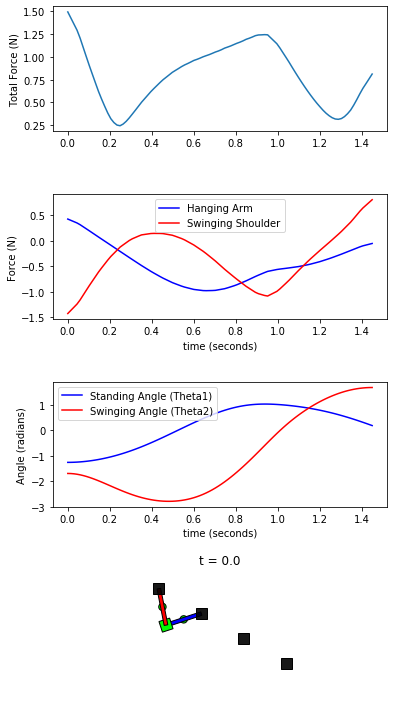

In [ ]:
# Consider adding in the floating base (we will need this for traj opt? and variable clinging?)
#monkey body base
monkey_base = """
    <link name="base">
        <inertial>
            <origin xyz="0 0 0" />
            <mass value="0" />
        </inertial>
    </link>

    
    <link name="floating_base_x" />    
    <link name="floating_base_z" />


    <joint name="joint_world_x" type="fixed">
        <parent link="bar0" />
        <child link="floating_base_x" />
        <origin  xyz="0 0 0" />
        <axis xyz="1 0 0" />
    </joint>

    <joint name="joint_x_z" type="fixed">
        <parent link="floating_base_x" />
        <child link="floating_base_z" />
        <origin  xyz="0 0 0" />
        <axis xyz="0 0 1" />
    </joint>

    <joint name="joint_z_base" type="fixed">
        <parent link="floating_base_z" />
        <child link="base" />
        <origin  xyz="0 0 0" />
    </joint>
"""

MONKEY_BODY_AND_BASE = """
  <!-- pendulum hanging from ceiling -->
  
  """ + monkey_base + """

  
  <link name="hanging_arm">
    <inertial>
      <origin xyz="0 0 -.5" />
      <mass value=".2" />
    </inertial>

    <visual>
      <origin xyz="0 0 -.5" />
      <geometry>
         <sphere radius=".1" />
      </geometry>
      <material>
        <color rgba="0 1 0 1" />
      </material>
    </visual>

    <visual>
      <origin xyz="0 0 -.5" />
      <geometry>
         <cylinder length="1" radius=".05" />
      </geometry>
      <material>
        <color rgba="0 0 1 1" />
      </material>
    </visual>
  </link>

  <joint name="bar_to_hanging" type="continuous">
    <parent link="base" />
    <child link="hanging_arm" />
    <axis xyz="0 -1 0" />
    <origin xyz="0 0 0"/>
  </joint>


  <!-- body -->

  <link name="body">
    <inertial>
      <origin xyz="0 0 0" />
      <mass value="1" />
    </inertial>

    <visual>
      <origin xyz="0 0 0" />
      <geometry>
         <box size="0.3 0.3 0.3" />
      </geometry>
      <material>
        <color rgba="0 1 0 1" />
      </material>
    </visual>
  </link>

  <joint name="hanging_to_body" type="fixed">
    <parent link="hanging_arm" />
    <child link="body" />
    <axis xyz="0 -1 0" />
    <origin xyz="0 0 -1"/>
  </joint>

  <!-- pendulum hanging from other pendulum -->

  <link name="swinging_arm">
    <inertial>
      <origin xyz="0 0 -.5" />
      <mass value=".2" />
    </inertial>

    <visual>
      <origin xyz="0 0 -.5" />
      <geometry>
         <sphere radius=".1" />
      </geometry>
      <material>
        <color rgba="0 1 0 1" />
      </material>
    </visual>

    <visual>
      <origin xyz="0 0 -.5" />
      <geometry>
         <cylinder length="1" radius=".05" />
      </geometry>
      <material>
        <color rgba="1 0 0 1" />
      </material>
    </visual>
  </link>

  <joint name="body_to_swinging" type="continuous">
    <parent link="body" />
    <child link="swinging_arm" />
    <axis xyz="0 -1 0" />
    <origin xyz="0 0 0"/>
  </joint>
  
  <transmission type="SimpleTransmission" name="base_force">
    <actuator name="force" />
    <joint name="bar_to_hanging" />
  </transmission>
<transmission type="SimpleTransmission" name="arm2_force">
    <actuator name="force1" />
    <joint name="body_to_swinging" />
  </transmission>

        </robot> """


# making the bars & completing the urdf
NUM_ACTUATORS = 2
X_RANGE = [1, 2]
Z_RANGE = [-.75, .75]
num_bars = 1
#_, bar1 = make_random_bars_urdf(num_bars, X_RANGE, Z_RANGE)
#bar1 = [1.9904724,  0.04561072]
bar1 = [ 1.14311973, -0.67153744]
#bar1 = [1.29380912, 0.35038471]
bar_params = [np.array([0, bar1[0], -2*bar1[0], 3*bar1[0]]), np.array([0, bar1[1], -2*bar1[1], 3*bar1[1]])]
urdf = create_monkey_urdf(MONKEY_BODY_AND_BASE, bar_params)
print(urdf)
# setting conditions for traj opt 
armlength = 1
final_state = compute_final_thetas(armlength, bar1) + [0] * 2
t1, t2 = final_state[:2]
initial_state = [-(np.pi - t1 - t2), - t2] + [0] * 2

print(bar1)

time_samples = 30
min_timestep = 0.03
max_timestep = 0.05
# add the specific constraints in the constraint input sec below
# add costs in cost sec below
##### END USER INPUT SEC ######

plant = MultibodyPlant(time_step=0.0)
scene_graph = SceneGraph()
plant.RegisterAsSourceForSceneGraph(scene_graph)
Parser(plant).AddModelFromString(urdf, "urdf")
plant.Finalize()

context = plant.CreateDefaultContext()
dircol = DirectCollocation(
    plant,
    context,
    num_time_samples=time_samples,
    minimum_timestep=min_timestep,
    maximum_timestep=max_timestep,
    input_port_index=plant.get_actuation_input_port().get_index())

# required constraints (dircol vs dircol.prog somewhat ambiguous, just try both)
init, fin = dircol.initial_state(), dircol.final_state()
#dircol.prog().AddConstraint(init[0] == init)
dircol.AddEqualTimeIntervalsConstraints()
dircol.prog().AddBoundingBoxConstraint(initial_state[:4], initial_state[:4], init[:4])
dircol.prog().AddBoundingBoxConstraint(final_state[:2], final_state[:2], fin[:2])


##### ADD CONSTRAINTS ######

#ADD OTHER CONSTRAINTS HERE
#1. finish by gong upwards not downwards (maybe don't want this actually)
dircol.prog().AddLinearConstraint(fin[-1] >= 0)

def dxdz(state):
    t1, t2 = state[:2]
    dx = np.sin(t1) + np.cos(t2)
    dz = -np.cos(t1) + np.sin(t2)
    return dx, dz

#2. never cross through the second bar (dx is negative, or dz is negative)
#for t in range(1,T-1):
#    dircol.prog().AddConstraint(swing_hand_height, lb=[-np.inf]*2, ub=0, vars=dircol.state(t))

#dircol.AddConstraintToAllKnotPoints(dxdz(dircol.state())[0] < bar1[0] or dxdz(dircol.state())[1] < bar1[1])

#3. the body doesn't go above the connecting line
nextbarangle = np.pi/2 + np.arctan(bar1[1]/bar1[0])
dircol.AddConstraintToAllKnotPoints(dircol.state()[0] <= nextbarangle)
dircol.AddConstraintToAllKnotPoints(dircol.state()[0] >= -np.pi + nextbarangle)

#4. the arm doesn't go above the 



##### ADD COSTS ######

R = 1  # Cost on input "effort".
u = dircol.input()
dircol.AddRunningCost(R * np.dot(u[:], u[:]))

# Add a final cost equal to the total duration.
dircol.AddFinalCost(dircol.time())

torquelimit = 2 #look at unconstrained problem to see what seems like unrealistic torques. Later use realistic model of masses.
for t in range(time_samples):
    dircol.prog().AddConstraint(np.dot(dircol.input(t), dircol.input(t)) <= torquelimit**2)

#dircol.prog().Add

#### END COSTS & CONSTRAINTS SECS ####



initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
    [0., 4.], np.column_stack((initial_state, final_state)))  # yapf: disable
dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)
result = Solve(dircol.prog())
assert result.is_success()
#print('Init and Final conditions chosen: ', init, fin)

#fig, ax = plt.subplots(2 + NUM_ACTUATORS, 1) 
fig, ax = plt.subplots(4, 1) 
fig.subplots_adjust(hspace=0.5)


# Animate the results.
# TODO(russt): Add some helper methods to make this workflow cleaner.
def animate(plant, x_trajectory):
    builder = DiagramBuilder()
    source = builder.AddSystem(TrajectorySource(x_trajectory))
    builder.AddSystem(scene_graph)
    pos_to_pose = builder.AddSystem(
        MultibodyPositionToGeometryPose(plant, input_multibody_state=True))
    builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
    builder.Connect(pos_to_pose.get_output_port(),
                    scene_graph.get_source_pose_port(plant.get_source_id()))
    visualizer = builder.AddSystem(
        PlanarSceneGraphVisualizer(scene_graph,
                                   xlim=[-4, 5],
                                   ylim=[-10, 9],
                                   #ax=ax[1+NUM_ACTUATORS]))
                                   ax=ax[3]))
    builder.Connect(scene_graph.get_query_output_port(),
                    visualizer.get_input_port(0))


    ### SIMULATE AND ANIMATE THE PLANT ###
    diagram = builder.Build()
    simulator = Simulator(diagram)
    simulator.set_publish_every_time_step(False) # makes sim faster

    # start recording the video for the animation of the simulation
    visualizer.start_recording()

    # reset initial time and state
    #context = simulator.get_mutable_context()
    #context.SetTime(0.)
    #context.SetContinuousState(x0)
    #context = simulator.get_mutable_context()
    #context.SetTime(1)

    # run sim
    simulator.Initialize()
    #context.SetTime(0.5)
    #simulator.Initialize()
    simulator.AdvanceTo(x_trajectory.end_time())
    
    # mess with sim to get a cool multi sim
    #x_trajectory.shiftRight(2)
    #simulator.AdvanceTo(3)

    # stop video
    visualizer.stop_recording()

    # construct animation
    ani = visualizer.get_recording_as_animation()
    # display animation below the cell
    display(HTML(ani.to_jshtml()))

    # reset to empty video
    visualizer.reset_recording()
    
u_trajectory = dircol.ReconstructInputTrajectory(result)
times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
u_lookup = np.vectorize(u_trajectory.value) 
#u_values = u_lookup(times) #original formulation doesn't vectorize well 

# norm graph
u_values = [np.linalg.norm(u_lookup(time)) for time in times]
ax[0].plot(times, u_values)
ax[0].set_ylabel("Total Force (N)")

# each individual plot
colors = ['blue', 'red']
yaxis = ["Hanging Arm", "Swinging Shoulder"]
axi = 1
ax[axi].set_xlabel("time (seconds)")
ax[axi].set_ylabel("Force (N)")
for i in range(NUM_ACTUATORS): 
    #axi = 1 + i
    u_values = [u_lookup(time)[i] for time in times]
    ax[axi].plot(times, u_values, color= colors[i], label=yaxis[i])
    # ax[axi].set_ylabel(yaxis[i])
    #if i == NUM_ACTUATORS - 1:
    #    ax[axi].set_xlabel("time (seconds)")
ax[axi].legend()

x_trajectory = dircol.ReconstructStateTrajectory(result)
#pp = PiecewisePolynomial.ZeroOrderHold(np.arange(0, 1, .05), np.array([bar1]*20))  # yapf: disable#
#pp += x_trajectory 
#for t in np.arange(0, 1, .05):
#    print(pp.value(t), x_trajectory.value(t))
#x_trajectory = pp


# each individual plot
colors = ['blue', 'red']
yaxis = ["Standing Angle (Theta1)", "Swinging Angle (Theta2)"]
axi = 2
ax[axi].set_xlabel("time (seconds)")
ax[axi].set_ylabel("Angle (radians)")
for i in range(2): 
    #axi = 1 + i
    x_values = [x_trajectory.value(time)[i] for time in times]
    ax[axi].plot(times, x_values, color= colors[i], label=yaxis[i])
ax[axi].legend()

animate(plant, x_trajectory)

plt.show()

## Demonstrate the limit cycle as it goes up multiple rungs

Show the swinging, because it would look cool. Rather than just a single swing. 

## Add Body to the URDF

Obviously, we want to work with a body, and not just two arms. 

## Single Round & Then Arbitrary Recomputation

We want to do a simulation where we can put the bars wherever and the monkey will swing. This can certainly be solved by using the above algorithm or something even better where you don't need the limit cycle condition. Then we can just let the body come to rest and then recompute what it needs to do to get to the next configuratoin. 

## Challenge: Optimizing over multiple rungs

Theoretically, we would not want to cancel out the dynamics, but rather use them to our advantage. So, it would be most cool (and the driving motivator for choosing this project) to create a way to see how the optimization would work when you don't have to come to a full stop. We would need to make contact rules. This, we predict, is a rich rich ground for exploration, even simply with consistent bars, but most interestingly with randomized bars. 

## ilqr for one segment

The following is a condensed transcription of the steps necessary to do ilqr from observing the notebook we completed for homework. 

- continuous time dynamics
- discrete dynamics
- guess control trajectory u[0:N-1] and rollout states x[0:N]
- define stage cost and final cost
- this can be written as a cost over full trajectory
- get Q derivatives in form of taylor expansion of simpler derivs
- linear in x approximation for delta u optimal
- value update from q function
- get expected cost reduction
- forward pass, u = u + k + Kx updates all x and u states
- backward pass computes next k and K
- main loop (alter forward/backward, change regularization if proposed step bad, iterate until max_steps / no cost drop)
- plot

We must implement: the dynamics, and the stage/final costs, and maybe alter the main loop


It would be cool to optimize over multiple steps but it is unclear to me whether such a hybrid system would work. For example two steps because we have to deal with the instantaneous transfer of control so our restriction is something like (at some timestep t we hit the forward arm on the next rung) which seems hard to write down. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=18990445-f6e7-4d8c-9e5b-73c061f7343e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>